<a href="https://colab.research.google.com/github/FedericaBucco/MLAIHW2/blob/master/Copy_of_Homework2_MLDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Install requirements**

In [ ]:
from torchvision.datasets import VisionDataset

from PIL import Image

import os
import os.path
import sys


def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


def make_dataset(root, fileName, class_to_idx):
    fName = "./Caltech101/{0}.txt".format(fileName)
    dataset = list()
    with open(fName,'r') as f:
      for line in f:
        if line.find('BACKGROUND_Google')==-1:
            line = line.split('\n')[0]
            className = line.split('/')[0]
            dataset.append((pil_loader("{0}/{1}".format(root,line)), class_to_idx[className]))
    return dataset

class Caltech(VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None):
        super(Caltech, self).__init__(root, transform=transform, target_transform=target_transform)

        self.split = split # This defines the split you are going to use
                           # (split files are called 'train.txt' and 'test.txt')
        
        '''
        - Here you should implement the logic for reading the splits files and accessing elements
        - If the RAM size allows it, it is faster to store all data in memory
        - PyTorch Dataset classes use indexes to read elements
        - You should provide a way for the __getitem__ method to access the image-label pair
          through the index
        - Labels should start from 0, so for Caltech you will have lables 0...100 (excluding the background class) 
        '''
        self.root = root
        self.classes, self.class_to_idx = self._find_classes(self.root)
        self.samples = make_dataset(self.root, self.split, self.class_to_idx)
        self.targets = [s[1] for s in self.samples]
    
    def _find_classes(self, dir: str):
        """
        Finds the class folders in a dataset.

        Args:
            dir (string): Root directory path.

        Returns:
            tuple: (classes, class_to_idx) where classes are relative to (dir), and class_to_idx is a dictionary.

        Ensures:
            No class is a subdirectory of another.
        """
        classes = [d.name for d in os.scandir(dir) if d.is_dir() and d.name!='BACKGROUND_Google']
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

    def __getitem__(self, index):
        """
        __getitem__ should access an element through its index
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """

        image, label = self.samples[index]

        # Applies preprocessing when accessing the image
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        '''
        The __len__ method returns the length of the dataset
        It is mandatory, as this is used by several other components
        '''
        length = len(self.samples)
        return length


In [ ]:
!pip3 install 'torch==1.4.0'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

  Using cached https://files.pythonhosted.org/packages/24/19/4804aea17cd136f1705a5e98a00618cb8f6ccc375ad8bfa437408e09d058/torch-1.4.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: torch 1.7.0
    Uninstalling torch-1.7.0:
      Successfully uninstalled torch-1.7.0


In [ ]:
!python --version

Python 3.6.9


# New Section

**Import libraries**

In [ ]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

**Set Arguments**

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [ ]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

**Prepare Dataset**

In [ ]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/FedericaBucco/MLAIHW2.git
  !mv 'MLAIHW2' 'Caltech101'


DATA_DIR = '/content/Caltech101/101_ObjectCategories'

#from Caltech101.caltech_dataset import Caltech


# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

#I decide to splitt in odd and even number. Samples are ordered for classes, and
#to obtain a bilanced division is useful to use numbers
train_indexes = range(1,len(train_dataset),2)
val_indexes = range(0,len(train_dataset),2)


val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))



Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


**Prepare Dataloaders**

In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [ ]:
net = alexnet() # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

**Prepare Training**

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [ ]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  #FOR EACH EPOCH
  net.train(True) # Set Network to evaluation mode
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  for images, labels in train_dataloader:
    #FOR EACH IMAGE IN EACH EPOCH
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))
      train_loss.append(loss.item())
    
    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy - FOR EACH EPOCH
  accuracyt = running_corrects / float(len(val_dataset))
  train_acc.append(accuracyt)
  
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode

  running_corrects = 0
  current_stepv = 0
  #FOR EACH EPOCH I VALIDATE
  for images, labels in tqdm(val_dataloader):

    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Compute loss based on output and ground truth - ON VALIDATION
    loss = criterion(outputs, labels)
     # Log loss
    if current_stepv % LOG_FREQUENCY == 0:
      val_loss.append(loss.item())
     

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()
    current_stepv += 1
  # Calculate Accuracy - FOR EACH EPOCH ON VALIDATION
  accuracy = running_corrects / float(len(val_dataset))
  val_acc.append(accuracy)

  print('Validation Accuracy: {}'.format(accuracy))

  # Step the scheduler
  scheduler.step() 

Starting epoch 1/30, LR = [1.0000000000000002e-06]
Step 0, Loss 2.6261892318725586
Step 10, Loss 2.745682716369629


100%|██████████| 12/12 [00:05<00:00,  2.25it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 2/30, LR = [1.0000000000000002e-06]


Step 20, Loss 2.817690849304199


100%|██████████| 12/12 [00:05<00:00,  2.25it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 3/30, LR = [1.0000000000000002e-06]


Step 30, Loss 2.4063124656677246


100%|██████████| 12/12 [00:05<00:00,  2.28it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 4/30, LR = [1.0000000000000002e-06]


Step 40, Loss 2.6528263092041016


100%|██████████| 12/12 [00:05<00:00,  2.24it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 5/30, LR = [1.0000000000000002e-06]


Step 50, Loss 2.666100263595581


100%|██████████| 12/12 [00:05<00:00,  2.25it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 6/30, LR = [1.0000000000000002e-06]


Step 60, Loss 2.6512460708618164


100%|██████████| 12/12 [00:05<00:00,  2.23it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 7/30, LR = [1.0000000000000002e-06]


Step 70, Loss 2.4673702716827393


100%|██████████| 12/12 [00:05<00:00,  2.25it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 8/30, LR = [1.0000000000000002e-06]


Step 80, Loss 2.567134380340576


100%|██████████| 12/12 [00:05<00:00,  2.30it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 9/30, LR = [1.0000000000000002e-06]


Step 90, Loss 2.551593780517578


100%|██████████| 12/12 [00:05<00:00,  2.28it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 10/30, LR = [1.0000000000000002e-06]


Step 100, Loss 2.5658152103424072


100%|██████████| 12/12 [00:05<00:00,  2.26it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 11/30, LR = [1.0000000000000004e-08]


Step 110, Loss 2.616726875305176
Step 120, Loss 2.5282866954803467


100%|██████████| 12/12 [00:05<00:00,  2.27it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 12/30, LR = [1.0000000000000002e-07]


Step 130, Loss 2.492886543273926


100%|██████████| 12/12 [00:05<00:00,  2.29it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 13/30, LR = [1.0000000000000002e-07]


Step 140, Loss 2.589751720428467


100%|██████████| 12/12 [00:05<00:00,  2.29it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 14/30, LR = [1.0000000000000002e-07]


Step 150, Loss 2.671647310256958


100%|██████████| 12/12 [00:05<00:00,  2.28it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 15/30, LR = [1.0000000000000002e-07]


Step 160, Loss 2.519231081008911


100%|██████████| 12/12 [00:05<00:00,  2.31it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 16/30, LR = [1.0000000000000002e-07]


Step 170, Loss 2.4684388637542725


100%|██████████| 12/12 [00:05<00:00,  2.32it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 17/30, LR = [1.0000000000000002e-07]


Step 180, Loss 2.7412304878234863


100%|██████████| 12/12 [00:05<00:00,  2.28it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 18/30, LR = [1.0000000000000002e-07]


Step 190, Loss 2.8046178817749023


100%|██████████| 12/12 [00:05<00:00,  2.32it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 19/30, LR = [1.0000000000000002e-07]


Step 200, Loss 2.5982584953308105


100%|██████████| 12/12 [00:05<00:00,  2.32it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 20/30, LR = [1.0000000000000002e-07]


Step 210, Loss 2.6053295135498047


100%|██████████| 12/12 [00:05<00:00,  2.35it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 21/30, LR = [1.0000000000000002e-07]


Step 220, Loss 2.6365551948547363
Step 230, Loss 2.430974245071411


100%|██████████| 12/12 [00:05<00:00,  2.36it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 22/30, LR = [1.0000000000000002e-07]


Step 240, Loss 2.6366000175476074


100%|██████████| 12/12 [00:05<00:00,  2.37it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 23/30, LR = [1.0000000000000002e-07]


Step 250, Loss 2.6537115573883057


100%|██████████| 12/12 [00:05<00:00,  2.36it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 24/30, LR = [1.0000000000000002e-07]


Step 260, Loss 2.404421091079712


100%|██████████| 12/12 [00:05<00:00,  2.31it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 25/30, LR = [1.0000000000000002e-07]


Step 270, Loss 2.597835063934326


100%|██████████| 12/12 [00:05<00:00,  2.35it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 26/30, LR = [1.0000000000000002e-07]


Step 280, Loss 2.565572738647461


100%|██████████| 12/12 [00:05<00:00,  2.36it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 27/30, LR = [1.0000000000000002e-07]


Step 290, Loss 2.593677043914795


100%|██████████| 12/12 [00:05<00:00,  2.39it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 28/30, LR = [1.0000000000000002e-07]


Step 300, Loss 2.552321195602417


100%|██████████| 12/12 [00:04<00:00,  2.41it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 29/30, LR = [1.0000000000000002e-07]


Step 310, Loss 2.862713098526001


100%|██████████| 12/12 [00:04<00:00,  2.44it/s]

Validation Accuracy: 0.3475103734439834
Starting epoch 30/30, LR = [1.0000000000000002e-07]


Step 320, Loss 2.682330369949341


100%|██████████| 12/12 [00:05<00:00,  2.34it/s]

Validation Accuracy: 0.3475103734439834


33
30
60
30


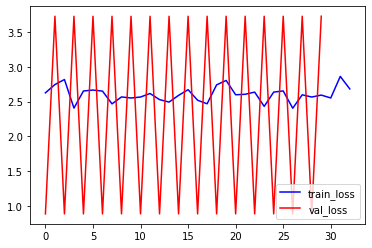

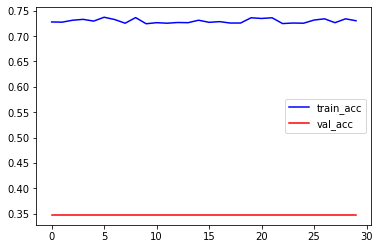

In [ ]:
#GRAFICI
import matplotlib.pyplot as plt 
print(len(train_loss))
print(len(train_acc))
print(len(val_loss))
print(len(val_acc))

plt.plot(range(len(train_loss)), train_loss, c = 'blue')

plt.plot(range(0,30), val_loss[:30], c = 'red')
labels = ["train_loss", "val_loss"]
plt.legend(labels)
plt.show()

plt.plot(range(len(train_acc)), train_acc, c = 'blue')
plt.plot(range(0,30), val_acc[:30], c = 'red')
labels = ["train_acc", "val_acc"]
plt.legend(labels)
plt.show()

**Validation**

In [65]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0


for images, labels in tqdm(val_dataloader):

  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(val_dataset))

print('Validation Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:05<00:00,  2.27it/s]

Validation Accuracy: 0.3475103734439834


**Test**

In [66]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:05<00:00,  2.31it/s]

Test Accuracy: 0.35153819564465955
